In [2]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming
from nltk.metrics.scores import recall

from nltk.corpus import stopwords

%matplotlib inline

In [3]:
from bow_run import *

In [4]:
%run utils.ipynb

In [5]:
google_s2t_hyps, google_s2t_refs, google_s2t_refs_for_eval = get_google_data()
google_hyp_r0 = google_s2t_hyps['fisher_dev_r0']
google_dev_ref_0 = google_s2t_refs['fisher_dev_ref_0']

eval refs found, loading


In [6]:
edin_150hrs_path = "./sp2enw/sp_1.0_h512_rnn4_l2e-4/"
edin_150hrs_refs = pickle.load(open(os.path.join(edin_150hrs_path, "model_s2t_refs.dict"), "rb"))
edin_150hrs_hyps = pickle.load(open(os.path.join(edin_150hrs_path, "model_s2t_hyps.dict"), "rb"))
edin_150hrs_refs_for_eval = pickle.load(open(os.path.join(edin_150hrs_path, "model_s2t_refs_for_eval.dict"), "rb"))

In [7]:
edin_150hrs_refs_for_eval['20051009_182032_217_fsp-A-1']

[['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon']]

In [8]:
edin_150hrs_refs['20051009_182032_217_fsp-A-1']

['good', 'afternoon']

In [9]:
# edin_50hrs_path = "./sp2enw/sp_.33"
edin_50hrs_path = "./sp2enw_mel-80_vocab-nltk/sp_0.33_h-256_e-128_l2e-3_lstm_drpt-0.3_cnn-32-2-2_rnn-3_b-40-50"
edin_50hrs_refs = pickle.load(open(os.path.join(edin_50hrs_path, "model_s2t_refs.dict"), "rb"))
edin_50hrs_hyps = pickle.load(open(os.path.join(edin_50hrs_path, "model_s2t_hyps.dict"), "rb"))
edin_50hrs_refs_for_eval = pickle.load(open(os.path.join(edin_50hrs_path, "model_s2t_refs_for_eval.dict"), "rb"))

In [10]:
edin_50hrs_refs_for_eval['20051009_182032_217_fsp-A-1']

[['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon']]

In [11]:
edin_50hrs_hyps['20051009_182032_217_fsp-A-1']

['good', 'afternoon']

In [12]:
google_s2t_refs_for_eval['20051009_182032_217_fsp-A-1']

[['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon'],
 ['good', 'afternoon']]

In [13]:
google_hyp_r0['20051009_182032_217_fsp-A-1']

['good', 'afternoon']

In [14]:
edin_25hrs_path = "sp2enw_mel-80_vocab-nltk/sp_0.16_h-256_e-128_l2e-3_lstm_drpt-0.3_cnn-32-2-2_rnn-3_b-80-25_no-ln-bn"
edin_25hrs_refs = pickle.load(open(os.path.join(edin_25hrs_path, "model_s2t_refs.dict"), "rb"))
edin_25hrs_hyps = pickle.load(open(os.path.join(edin_25hrs_path, "model_s2t_hyps.dict"), "rb"))
edin_25hrs_refs_for_eval = pickle.load(open(os.path.join(edin_25hrs_path, "model_s2t_refs_for_eval.dict"), "rb"))

In [15]:
edin_15hrs_path = "./sp2enw/sp_.10"
edin_15hrs_refs = pickle.load(open(os.path.join(edin_15hrs_path, "model_s2t_refs.dict"), "rb"))
edin_15hrs_hyps = pickle.load(open(os.path.join(edin_15hrs_path, "model_s2t_hyps.dict"), "rb"))
edin_15hrs_refs_for_eval = pickle.load(open(os.path.join(edin_15hrs_path, "model_s2t_refs_for_eval.dict"), "rb"))

## Edin model

In [21]:
cfg_path = "sp2bagwords/sp_0.50_trial-A/"

In [22]:
last_epoch, model, optimizer, m_cfg, t_cfg = check_model(cfg_path)

cnn_out_dim = rnn_in_units =  640


/afs/inf.ed.ac.uk/group/project/lowres/work/miniconda3/envs/chainer3/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer
--------------------------------------------------------------------------------
model not found


In [23]:
%%capture
train_key = m_cfg['train_set']
dev_key = m_cfg['dev_set']
batch_size=t_cfg['batch_size']
enc_key=m_cfg['enc_key']
dec_key=m_cfg['dec_key']
input_path = os.path.join(m_cfg['data_path'], m_cfg['dev_set'])
# -------------------------------------------------------------------------
# get data dictionaries
# -------------------------------------------------------------------------
map_dict, vocab_dict, bucket_dict, bow_dict = get_data_dicts(m_cfg)
if os.path.exists(os.path.join(m_cfg['model_dir'], "model_s2t_dev_out.dict")):
    dev_utts = pickle.load(open(os.path.join(m_cfg['model_dir'], "model_s2t_dev_out.dict"), "rb"))

if os.path.exists(os.path.join(m_cfg['model_dir'], "model_s2t_train_out.dict")):
    train_utts = pickle.load(open(os.path.join(m_cfg['model_dir'], "model_s2t_train_out.dict"), "rb"))
# batch_size = {'max': 128, 'med': 128, 'min': 128, 'scale': 1}
batch_size = {'max': 64, 'med': 64, 'min': 64, 'scale': 1}
batch_size = t_cfg['batch_size']

edin_s2t_refs_for_eval_path = os.path.join("../chainer2/speech2text/both_fbank_out/", 
                                           "edin_s2t_refs_for_eval.dict")
edin_s2t_refs_for_eval = pickle.load(open(edin_s2t_refs_for_eval_path, "rb"))
single_dev_ref = [[i[0]] for i in dev_utts["refs"]]

In [ ]:
map_dict["fisher_dev"]['20051009_182032_217_fsp-B-1'].keys()

In [ ]:
input_path = os.path.join(m_cfg['data_path'],
                                      m_cfg['train_set'])
train_utts, train_loss = feed_model(model,
                              optimizer=optimizer,
                              m_dict=map_dict[train_key],
                              b_dict=bucket_dict[train_key],
                              vocab_dict=vocab_dict,
                              bow_dict=bow_dict,
                              batch_size=batch_size,
                              x_key=enc_key,
                              y_key=dec_key,
                              train=False,
                              input_path=input_path,
                              max_dec=m_cfg['max_en_pred'],
                              t_cfg=t_cfg,
                              use_y=True,
                              get_probs=True)

In [ ]:
# pickle.dump(train_utts, open(os.path.join(m_cfg['model_dir'], "model_s2t_train_out.dict"), "wb"))

In [ ]:
mean_pos_scores = np.array([0.0 for _ in bow_dict["i2w"]], dtype="f")
mean_neg_scores = np.array([0.0 for _ in bow_dict["i2w"]], dtype="f")


for i_w in range(4, len(bow_dict["i2w"])):
    this_word = bow_dict["i2w"][i_w]
    pos_indx = [i_w in r[0] for r in train_utts["refs"]]
    neg_indx = [i_w not in r[0] for r in train_utts["refs"]]
    mean_pos_scores[i_w] = np.mean(train_utts["probs"][:,i_w][pos_indx])
    mean_neg_scores[i_w] = np.mean(train_utts["probs"][:,i_w][neg_indx])

In [ ]:
xp.mean(mean_pos_scores), xp.mean(mean_neg_scores)

In [ ]:
train_avg_p, _ = compute_avg_precision(train_utts["probs"],
                                                     0.0, 1.0, 5,
                                                     m_cfg['max_en_pred'],
                                                     train_utts["refs"])
train_avg_p

In [ ]:
THRESH = m_cfg["pred_thresh"]
train_pred_words = get_pred_words_from_probs(train_utts["probs"],
#                                              mean_pos_scores,
                                               0.5,
                                               m_cfg['max_en_pred'])

train_prec, train_rec, _ = basic_precision_recall(train_utts["refs"], train_pred_words)
train_prec, train_rec

In [ ]:
input_path = os.path.join(m_cfg['data_path'], m_cfg['dev_set'])

dev_utts, dev_loss = feed_model(model,
                                optimizer=optimizer,
                                m_dict=map_dict[dev_key],
                                b_dict=bucket_dict[dev_key],
                                vocab_dict=vocab_dict,
                                bow_dict=bow_dict,
                                batch_size=batch_size,
                                x_key=enc_key,
                                y_key=dec_key,
                                train=False,
                                input_path=input_path,
                                max_dec=m_cfg['max_en_pred'],
                                t_cfg=t_cfg,
                                use_y=True,
                                get_probs=True)

In [ ]:
single_dev_ref = [[i[0]] for i in dev_utts["refs"]]

In [ ]:
np.min(dev_utts["probs"]), np.max(dev_utts["probs"])

In [ ]:
mean_dev_pos_scores = np.array([0.0 for _ in bow_dict["i2w"]], dtype="f")
mean_dev_neg_scores = np.array([0.0 for _ in bow_dict["i2w"]], dtype="f")


for i_w in range(4, len(bow_dict["i2w"])):
    this_word = bow_dict["i2w"][i_w]
    pos_indx = [i_w in r[0] for r in dev_utts["refs"]]
    neg_indx = [i_w not in r[0] for r in dev_utts["refs"]]
    mean_dev_pos_scores[i_w] = np.mean(dev_utts["probs"][:,i_w][pos_indx])
    mean_dev_neg_scores[i_w] = np.mean(dev_utts["probs"][:,i_w][neg_indx])

In [ ]:
PRED_THRESH = 0.2
print("using prediction threshold={0:.2f}".format(PRED_THRESH))
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                           PRED_THRESH,
                                           len(bow_dict['i2w']))
p, r, haha = basic_precision_recall(dev_utts["refs"], dev_pred_words)
print(p,r)
print("using mean positive prediction threshold")
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                               mean_dev_pos_scores,
                                               m_cfg['max_en_pred'])
p, r, _ = basic_precision_recall(dev_utts["refs"], dev_pred_words)
print(p,r)

In [ ]:
PRED_THRESH = 0.1
print("using prediction threshold={0:.2f}".format(PRED_THRESH))
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                           PRED_THRESH,
                                           len(bow_dict['i2w']))
p, r, _ = basic_precision_recall(single_dev_ref, dev_pred_words)
print(p,r)
print("using mean positive prediction threshold")
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                               mean_dev_pos_scores,
                                               m_cfg['max_en_pred'])
p, r, _ = basic_precision_recall(single_dev_ref, dev_pred_words)
print(p,r)

In [ ]:
min_prob, max_prob = float(xp.min(dev_utts["probs"])), float(xp.max(dev_utts["probs"]))
min_prob, max_prob

### Precision-Recall Plot - word level threshold

In [ ]:
np.arange(-0.5, 0.5, 0.1)

In [ ]:
mean_pos_scores[4:14]*1.3

In [ ]:
thresh_deltas = np.asarray([0.7,0.8,0.9,1,1.1,1.2,1.3], dtype="f")

In [ ]:
p_r_thresh = {}
thresh_delta = 0.05
for thresh in tqdm(np.arange(-0.5, 0.5+thresh_delta, thresh_delta)):
# for thresh in tqdm(thresh_deltas):
# for thresh in tqdm(np.linspace(min_prob, max_prob,num=20,endpoint=True)):
    p_r_thresh[thresh] = {}
    dev_pred_words_at_thresh = get_pred_words_from_probs(dev_utts["probs"],
                                                           mean_pos_scores + thresh,
                                                           len(bow_dict['i2w']))
    p_r_thresh[thresh]['p'], p_r_thresh[thresh]['r'], _ = basic_precision_recall(dev_utts["refs"], 
                                                                              dev_pred_words_at_thresh)
    

In [ ]:
thresh_labels, p_vals, r_vals = [], [], []
for l in p_r_thresh:
    p_vals.append(p_r_thresh[l]["p"])
    r_vals.append(p_r_thresh[l]["r"])
    thresh_labels.append("{0:.2f}".format(l))

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(r_vals, p_vals, label="Precision/Recall")
for i,j,k in zip(r_vals, p_vals, thresh_labels):
    ax.annotate(k,xy=(i,j), fontsize=12)
ax.set_ylabel("Precision", fontsize=28)
ax.set_xlabel("Recall", fontsize=26)
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 0.9),
                  ncol=1, fancybox=True, shadow=True, fontsize=26)

plt.yticks(rotation=0, size=18)
plt.xticks(rotation=0, size=18)

### Precision-Recall Plot - fixed threshold

In [ ]:
len(dev_utts["probs"][0]), len(bow_dict['i2w'])

In [ ]:
def compute_avg_precision(probs, min_prob, max_prob, num_points, max_words, refs):
    p_r_thresh = {}
    for thresh in tqdm(np.linspace(min_prob, max_prob, num=num_points, endpoint=True)):
        p_r_thresh[thresh] = {}
        words_at_thresh = get_pred_words_from_probs(probs, thresh, max_words)
        p_r_thresh[thresh]['p'], p_r_thresh[thresh]['r'], _ = basic_precision_recall(refs, words_at_thresh)
    
    precision_array = np.array([p_r_thresh[i]['p']/100 for i in p_r_thresh], dtype="f")
    recall_array = np.array([p_r_thresh[i]['r']/100 for i in p_r_thresh], dtype="f")
    avg_p = np.trapz(precision_array[::-1], recall_array[::-1])
    return avg_p, p_r_thresh
    

In [ ]:
avg_p, p_r_thresh = compute_avg_precision(dev_utts["probs"], 0.0, 1.0, 50, 104, dev_utts["refs"])

In [ ]:
avg_p

In [ ]:
# p_r_thresh = {}
# thresh_delta = 0.01
# # for thresh in tqdm(np.arange(min_prob, max_prob+thresh_delta,thresh_delta)):
# for thresh in tqdm(np.linspace(min_prob, max_prob, num=30,endpoint=True)):
#     p_r_thresh[thresh] = {}
#     dev_pred_words_at_thresh = get_pred_words_from_probs(dev_utts["probs"],
#                                                            thresh,
#                                                            len(bow_dict['i2w']))
#     p_r_thresh[thresh]['p'], p_r_thresh[thresh]['r'], _ = basic_precision_recall(dev_utts["refs"], 
#                                                                               dev_pred_words_at_thresh)
    

In [ ]:
thresh_labels, p_vals, r_vals = [], [], []
for l in p_r_thresh:
    p_vals.append(p_r_thresh[l]["p"])
    r_vals.append(p_r_thresh[l]["r"])
    thresh_labels.append("{0:.2f}".format(l))

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(r_vals, p_vals, label="Precision/Recall")
for i,j,k in zip(r_vals, p_vals, thresh_labels):
    ax.annotate(k,xy=(i,j), fontsize=12)
ax.set_ylabel("Precision", fontsize=28)
ax.set_xlabel("Recall", fontsize=26)
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 0.9),
                  ncol=1, fancybox=True, shadow=True, fontsize=26)

plt.yticks(rotation=0, size=18)
plt.xticks(rotation=0, size=18)

In [ ]:
PRED_THRESH = 0.15
print("using prediction threshold={0:.2f}".format(PRED_THRESH))
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                           PRED_THRESH,
                                           len(bow_dict['i2w']))
p, r, _ = basic_precision_recall(single_dev_ref, dev_pred_words)
print(p,r)
# print("using mean positive prediction threshold")
# dev_mean_pred_words = get_pred_words_from_probs(dev_utts["probs"],
#                                            mean_pos_scores,
#                                            m_cfg['max_en_pred'])
# p, r, _ = basic_precision_recall(single_dev_ref, dev_mean_pred_words)
# print(p,r)

In [83]:
PRED_THRESH = 0.01
print("using prediction threshold={0:.2f}".format(PRED_THRESH))
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                           PRED_THRESH,
                                           len(bow_dict['i2w']))
p, r, _ = basic_precision_recall(dev_utts["refs"], dev_pred_words)
print(p,r)
# print("using mean positive prediction threshold")
# dev_mean_pred_words = get_pred_words_from_probs(dev_utts["probs"],
#                                            mean_pos_scores,
#                                            m_cfg['max_en_pred'])
# p, r, _ = basic_precision_recall(single_dev_ref, dev_mean_pred_words)
# print(p,r)

using prediction threshold=0.01
4.965296316070475 8.837656099903938


In [ ]:
precision_array = np.array([p_r_thresh[i]['p']/100 for i in p_r_thresh], dtype="f")
recall_array = np.array([p_r_thresh[i]['r']/100 for i in p_r_thresh], dtype="f")

In [ ]:
precision_array[::-1]

In [ ]:
np.trapz(precision_array[::-1], recall_array[::-1])

### get preds and refs in words

In [81]:
list(zip(train_pred_words, train_utts["refs"]))[:10]

NameError: name 'train_pred_words' is not defined

In [84]:
dev_utt_preds_words = {}
dev_utt_refs_words = {}
for u, p, refs in zip(dev_utts['ids'], dev_pred_words, dev_utts["refs"]):
    dev_utt_preds_words[u] = list(set([bow_dict['i2w'][i].decode() for i in p]))
    dev_utt_refs_words[u] = []
    for r in refs:
        #print(r)
        dev_utt_refs_words[u].append([bow_dict['i2w'][i].decode() for i in set(r)])
single_dev_ref_words = {u: [dev_utt_refs_words[u][0]] for u in dev_utt_refs_words}

In [85]:
p, r, metric = basic_precision_recall(list(dev_utt_refs_words.values()), list(dev_utt_preds_words.values()))
p, r

(4.965296316070475, 8.837656099903938)

In [86]:
ps, rs, _ = basic_precision_recall(single_dev_ref_words.values(), dev_utt_preds_words.values())
ps, rs

(3.737319807794982, 6.782945736434108)

In [ ]:
[(k, metric[k]) for k in ['rc', 'rt', 'tp', 'tc']]

In [ ]:
words_correctly_predicted = [item for item in metric["word"].items() if item[1]['tc'] > 0]
print(len(words_correctly_predicted))
display(words_correctly_predicted)

In [ ]:
# most common train words
[w.decode() for w, f in sorted(bow_dict['freq'].items(), reverse=True, key=lambda t: t[1])][:10]

In [ ]:
list(single_dev_ref_words.items())[:5]

In [ ]:
display_bow_words(single_dev_ref_words, 
                  dev_utt_preds_words, 
                  bow_dict, 
                  map_dict["fisher_dev"], display_num=100)

## Google model

In [24]:
dev_utt_ids = list(edin_150hrs_hyps.keys())

In [25]:
google_utt_preds_words_bow = {}
google_single_ref = {}
google_utt_refs_words_bow = {}
# for u in dev_utts['ids']:
for u in dev_utt_ids:
    google_utt_preds_words_bow[u] = list(get_words_in_bow_vocab(google_hyp_r0[u], bow_dict))
    google_utt_refs_words_bow[u] = []
    google_single_ref[u] = [list(get_words_in_bow_vocab(google_dev_ref_0[u], bow_dict))]
    for r in google_s2t_refs:
        google_utt_refs_words_bow[u].append(list(get_words_in_bow_vocab(google_s2t_refs[r][u], bow_dict)))

In [26]:
pg, rg, metrics_g = basic_precision_recall(google_utt_refs_words_bow.values(), google_utt_preds_words_bow.values())
pg, rg

(92.8169014084507, 87.60330578512396)

In [27]:
pg, rg, metrics_g = basic_precision_recall(google_single_ref.values(), google_utt_preds_words_bow.values())
pg, rg

(84.85207100591717, 69.54413191076625)

In [28]:
# display_bow_words(google_s2t_refs_for_eval, google_hyp_r0, bow_dict, map_dict["fisher_dev"], display_num=10)

In [29]:
# MT PRECISION RECALL - NOOOT BOW
p_nmt_g, r_nmt_g, metrics_nmt_g = basic_precision_recall(google_s2t_refs_for_eval.values(), google_hyp_r0.values())
p_nmt_g, r_nmt_g

(76.60378308943908, 67.74317866502236)

In [30]:
len(metrics_g["word"])

40

In [31]:
len([item for item in metrics_g["word"].items() if item[1]['tc'] > 0])

39

## Edin 150 hours model

In [32]:
len(edin_150hrs_hyps), len(dev_utt_ids)

(3977, 3977)

In [33]:
edin_150hrs_utt_preds_words_bow = {}
edin_150hrs_single_ref = {}
edin_150hrs_utt_refs_words_bow = {}
# for u in dev_utts['ids']:
for u in dev_utt_ids:
    edin_150hrs_utt_preds_words_bow[u] = list(get_words_in_bow_vocab(edin_150hrs_hyps[u], bow_dict))
    edin_150hrs_utt_refs_words_bow[u] = []
    edin_150hrs_single_ref[u] = [list(get_words_in_bow_vocab(edin_150hrs_refs[u], bow_dict))]
    for r in edin_150hrs_refs_for_eval[u]:
        edin_150hrs_utt_refs_words_bow[u].append(list(get_words_in_bow_vocab(r, bow_dict)))

In [34]:
p_edin_150, r_edin_150, metrics_edin_150 = basic_precision_recall(edin_150hrs_utt_refs_words_bow.values(), 
                                                                  edin_150hrs_utt_preds_words_bow.values())
p_edin_150, r_edin_150

(76.34920634920634, 62.98788694481831)

In [35]:
p_edin_150, r_edin_150, metrics_edin_150 = basic_precision_recall(edin_150hrs_single_ref.values(), edin_150hrs_utt_preds_words_bow.values())
p_edin_150, r_edin_150

(67.70428015564202, 50.337512054001934)

In [36]:
# display_bow_words(edin_150hrs_refs_for_eval, 
#                   edin_150hrs_hyps_dict, 
#                   bow_dict, map_dict["fisher_dev"], display_num=2)

In [37]:
# MT PRECISION RECALL - NOOOT BOW
p_nmt_edin150, r_nmt_edin150, metrics_nmt_edin150 = basic_precision_recall(edin_150hrs_refs_for_eval.values(), 
                                                                           edin_150hrs_hyps.values())
p_nmt_edin150, r_nmt_edin150

(57.432013464434405, 53.59567452235476)

In [38]:
len([item for item in metrics_edin_150["word"].items() if item[1]['tc'] > 0])

37

## Edin 50 hours model

In [39]:
edin_50hrs_utt_preds_words_bow = {}
edin_50hrs_single_ref = {}
edin_50hrs_utt_refs_words_bow = {}
# for u in dev_utts['ids']:
for u in dev_utt_ids:
    edin_50hrs_utt_preds_words_bow[u] = list(get_words_in_bow_vocab(edin_50hrs_hyps[u], bow_dict))
    edin_50hrs_utt_refs_words_bow[u] = []
    edin_50hrs_single_ref[u] = [list(get_words_in_bow_vocab(edin_50hrs_refs[u], bow_dict))]
    for r in edin_50hrs_refs_for_eval[u]:
        edin_50hrs_utt_refs_words_bow[u].append(list(get_words_in_bow_vocab(r, bow_dict)))

In [40]:
p_edin_50, r_edin_50, metrics_edin_50 = basic_precision_recall(edin_50hrs_utt_refs_words_bow.values(), 
                                                                  edin_50hrs_utt_preds_words_bow.values())
p_edin_50, r_edin_50

(60.77235772357723, 39.15343915343915)

In [41]:
p_edin_50, r_edin_50, metrics_edin_50 = basic_precision_recall(edin_50hrs_single_ref.values(), 
                                                               edin_50hrs_utt_preds_words_bow.values())
p_edin_50, r_edin_50

(51.14854517611026, 32.36434108527132)

In [42]:
len(metrics_edin_50['word'])

40

In [43]:
sorted(bow_dict['freq_dev'].items(), reverse=True, key=lambda t:t[1])

[(b'people', 204),
 (b'time', 142),
 (b'want', 97),
 (b'live', 84),
 (b'even', 73),
 (b'years', 68),
 (b'make', 62),
 (b'someone', 55),
 (b'need', 49),
 (b'another', 45),
 (b'house', 42),
 (b'city', 39),
 (b'help', 38),
 (b'give', 37),
 (b'girl', 34),
 (b'home', 34),
 (b'name', 32),
 (b'send', 29),
 (b'life', 25),
 (b'love', 25),
 (b'leave', 25),
 (b'lives', 24),
 (b'saying', 23),
 (b'remember', 21),
 (b'first', 20),
 (b'gets', 20),
 (b'high', 20),
 (b'coming', 20),
 (b'change', 19),
 (b'stay', 19),
 (b'watch', 16),
 (b'found', 15),
 (b'case', 14),
 (b'waiting', 13),
 (b'news', 11),
 (b'morning', 11),
 (b'women', 10),
 (b'terrible', 10),
 (b'town', 10),
 (b'huge', 10)]

In [44]:
sorted(metrics_edin_50['word'].items(), reverse=True, key=lambda t: t[1]["tc"])

[('people', {'t': 162, 'tc': 91, 'tp': 112}),
 ('years', {'t': 56, 'tc': 29, 'tp': 44}),
 ('time', {'t': 88, 'tc': 28, 'tp': 54}),
 ('want', {'t': 68, 'tc': 25, 'tp': 65}),
 ('live', {'t': 70, 'tc': 24, 'tp': 52}),
 ('house', {'t': 33, 'tc': 22, 'tp': 50}),
 ('city', {'t': 36, 'tc': 18, 'tp': 36}),
 ('life', {'t': 25, 'tc': 12, 'tp': 26}),
 ('name', {'t': 29, 'tc': 9, 'tp': 14}),
 ('send', {'t': 22, 'tc': 9, 'tp': 21}),
 ('help', {'t': 30, 'tc': 8, 'tp': 14}),
 ('love', {'t': 20, 'tc': 8, 'tp': 15}),
 ('first', {'t': 19, 'tc': 7, 'tp': 14}),
 ('remember', {'t': 17, 'tc': 7, 'tp': 16}),
 ('change', {'t': 15, 'tc': 5, 'tp': 11}),
 ('someone', {'t': 27, 'tc': 5, 'tp': 10}),
 ('need', {'t': 25, 'tc': 5, 'tp': 13}),
 ('another', {'t': 29, 'tc': 4, 'tp': 10}),
 ('women', {'t': 5, 'tc': 4, 'tp': 4}),
 ('lives', {'t': 16, 'tc': 3, 'tp': 5}),
 ('girl', {'t': 22, 'tc': 2, 'tp': 12}),
 ('stay', {'t': 11, 'tc': 2, 'tp': 12}),
 ('home', {'t': 15, 'tc': 1, 'tp': 1}),
 ('give', {'t': 21, 'tc': 1, 'tp

In [45]:
len(metrics_edin_50['word'])

40

In [46]:
len([w for w in metrics_edin_50['word'] if metrics_edin_50['word'][w]['tc'] > 0])

29

In [47]:
# display_bow_words(edin_150hrs_refs_for_eval, 
#                   edin_150hrs_hyps_dict, 
#                   bow_dict, map_dict["fisher_dev"], display_num=2)

In [48]:
# MT PRECISION RECALL - NOOOT BOW
p_nmt_edin50, r_nmt_edin50, metrics_nmt_edin50 = basic_precision_recall(edin_50hrs_refs_for_eval.values(), 
                                                                           edin_50hrs_hyps.values())
p_nmt_edin50, r_nmt_edin50

(46.0783308555903, 38.6676933012096)

In [49]:
len([item for item in metrics_edin_50["word"].items() if item[1]['tc'] > 0])

29

In [50]:
len([w.decode() for w in bow_dict['freq'].keys()][4:])

40

## Edin 25 hours model

In [51]:
edin_25hrs_utt_preds_words_bow = {}
edin_25hrs_single_ref = {}
edin_25hrs_utt_refs_words_bow = {}
# for u in dev_utts['ids']:
for u in dev_utt_ids:
    edin_25hrs_utt_preds_words_bow[u] = list(get_words_in_bow_vocab(edin_25hrs_hyps[u], bow_dict))
    edin_25hrs_utt_refs_words_bow[u] = []
    edin_25hrs_single_ref[u] = [list(get_words_in_bow_vocab(edin_25hrs_refs[u], bow_dict))]
    for r in edin_25hrs_refs_for_eval[u]:
        edin_25hrs_utt_refs_words_bow[u].append(list(get_words_in_bow_vocab(r, bow_dict)))

In [52]:
p_edin_25, r_edin_25, metrics_edin_25 = basic_precision_recall(edin_25hrs_utt_refs_words_bow.values(), 
                                                                  edin_25hrs_utt_preds_words_bow.values())
p_edin_25, r_edin_25

(43.81720430107527, 21.31578947368421)

In [53]:
p_edin_25, r_edin_25, metrics_edin_25 = basic_precision_recall(edin_25hrs_single_ref.values(), 
                                                               edin_25hrs_utt_preds_words_bow.values())
p_edin_25, r_edin_25

(35.32934131736527, 17.151162790697676)

In [ ]:
# display_bow_words(edin_150hrs_refs_for_eval, 
#                   edin_150hrs_hyps_dict, 
#                   bow_dict, map_dict["fisher_dev"], display_num=2)

In [54]:
# MT PRECISION RECALL - NOOOT BOW
p_nmt_edin25, r_nmt_edin25, metrics_nmt_edin25 = basic_precision_recall(edin_25hrs_refs_for_eval.values(), 
                                                                           edin_25hrs_hyps.values())
p_nmt_edin25, r_nmt_edin25

(37.60112641099683, 33.29547979361592)

In [55]:
len([item for item in metrics_edin_25["word"].items() if item[1]['tc'] > 0])

18

In [56]:
len([w.decode() for w in bow_dict['freq'].keys()][4:])

40

## Edin 15 hours model

In [57]:
edin_15hrs_utt_preds_words_bow = {}
edin_15hrs_single_ref = {}
edin_15hrs_utt_refs_words_bow = {}
# for u in dev_utts['ids']:
for u in dev_utt_ids:
    edin_15hrs_utt_preds_words_bow[u] = list(get_words_in_bow_vocab(edin_15hrs_hyps[u], bow_dict))
    edin_15hrs_utt_refs_words_bow[u] = []
    edin_15hrs_single_ref[u] = [list(get_words_in_bow_vocab(edin_15hrs_refs[u], bow_dict))]
    for r in edin_15hrs_refs_for_eval[u]:
        edin_15hrs_utt_refs_words_bow[u].append(list(get_words_in_bow_vocab(r, bow_dict)))

In [58]:
p_edin_15, r_edin_15, metrics_edin_15 = basic_precision_recall(edin_15hrs_utt_refs_words_bow.values(), 
                                                                  edin_15hrs_utt_preds_words_bow.values())
p_edin_15, r_edin_15

(23.696682464454977, 6.274007682458387)

In [59]:
p_edin_15, r_edin_15, metrics_edin_15 = basic_precision_recall(edin_15hrs_single_ref.values(), 
                                                               edin_15hrs_utt_preds_words_bow.values())
p_edin_15, r_edin_15

(18.40277777777778, 5.110896817743491)

In [60]:
# display_bow_words(edin_150hrs_refs_for_eval, 
#                   edin_150hrs_hyps_dict, 
#                   bow_dict, map_dict["fisher_dev"], display_num=2)

In [61]:
# MT PRECISION RECALL - NOOOT BOW
p_nmt_edin15, r_nmt_edin15, metrics_nmt_edin15 = basic_precision_recall(edin_15hrs_refs_for_eval.values(), 
                                                                           edin_15hrs_hyps.values())
p_nmt_edin15, r_nmt_edin15

(29.788672865595945, 25.48781648581763)

In [62]:
len([item for item in metrics_edin_15["word"].items() if item[1]['tc'] > 0])

10

In [63]:
len([w.decode() for w in bow_dict['freq'].keys()][4:])

40

### Dummy baseline

In [64]:
freq_sorted_words = [w.decode() for w,f in sorted(bow_dict['freq'].items(), reverse=True, key=lambda t: t[1])]

In [65]:
predict_top_K = 5
top_K_words = freq_sorted_words[:predict_top_K]

In [66]:
" --- ".join(top_K_words)

'people --- time --- years --- want --- live'

In [67]:
dummy_preds = [top_K_words for u in google_hyp_r0]

In [68]:
basic_precision_recall(google_utt_refs_words_bow.values(), dummy_preds)[:2]

(14.041811846689894, 52.01072386058981)

In [69]:
basic_precision_recall(google_single_ref.values(), dummy_preds)[:2]

(10.935960591133005, 43.06498545101843)

In [70]:
max_pred = 10

In [71]:
dummy_p_vals = np.zeros((max_pred), dtype="f")
dummy_r_vals = np.zeros((max_pred), dtype="f")

In [72]:
dummy_p_vals

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [73]:
p_r_dummy = {}
# for thresh in tqdm(np.arange(min_prob, max_prob+thresh_delta,thresh_delta)):
for num_pred in tqdm(range(0,max_pred)):
    top_K_words = freq_sorted_words[:num_pred+1]
    dummy_preds = [top_K_words for u in google_hyp_r0]
    dummy_p_vals[num_pred], dummy_r_vals[num_pred] = basic_precision_recall(google_utt_refs_words_bow.values(), 
                                                                            dummy_preds)[:2]
    

100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


In [74]:
dummy_p_vals /= 100.0
dummy_r_vals /= 100.0

In [75]:
np.trapz(dummy_p_vals, dummy_r_vals)

0.07356319

In [76]:
thresh_labels = range(1,max_pred+1)

(array([10., 20., 30., 40., 50., 60., 70.]),
 <a list of 7 Text xticklabel objects>)

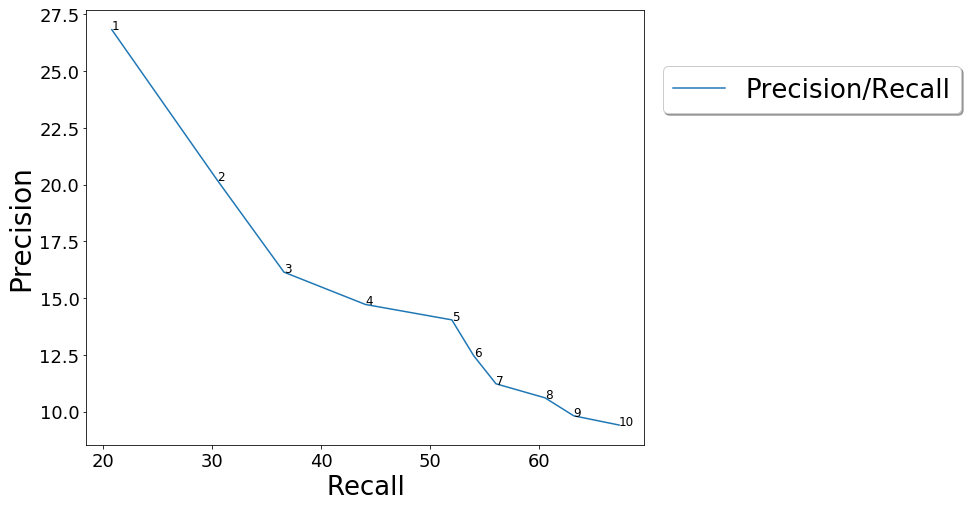

In [77]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(dummy_r_vals*100, dummy_p_vals*100, label="Precision/Recall")
for i,j,k in zip(dummy_r_vals*100, dummy_p_vals*100, thresh_labels):
    ax.annotate(k,xy=(i,j), fontsize=12)
ax.set_ylabel("Precision", fontsize=28)
ax.set_xlabel("Recall", fontsize=26)
ax.legend(loc='upper center', bbox_to_anchor=(1.3, 0.9),
                  ncol=1, fancybox=True, shadow=True, fontsize=26)

plt.yticks(rotation=0, size=18)
plt.xticks(rotation=0, size=18)

In [ ]:
# basic_precision_recall(single_dev_ref_words.values(), dummy_preds)[:2]

## Google refs vs Edin refs

In [87]:
sum([1 if len(r[0]) > 0 else 0 for r in single_dev_ref_words.values()])

3977

In [93]:
sum([len(set(r[0])-{'_UNK'})for r in single_dev_ref_words.values()])

1032

In [90]:
mismatch_count = 0
for u in set(google_single_ref.keys()) & set(single_dev_ref_words.keys()):
    if set(single_dev_ref_words[u][0]) - {'_UNK'} != set(google_single_ref[u][0]):
        mismatch_count += max(len(set(single_dev_ref_words[u][0]) - set(google_single_ref[u][0])), 
                              len(set(google_single_ref[u][0]) - set(single_dev_ref_words[u][0])))
        print(u, single_dev_ref_words[u], google_single_ref[u])
        print((set(single_dev_ref_words[u][0]) - set(google_single_ref[u][0])), 
                              (set(google_single_ref[u][0]) - set(single_dev_ref_words[u][0])))

20051018_210744_280_fsp-B-92 [['girl']] [[]]
{'girl'} set()


In [91]:
print(mismatch_count)

1


In [94]:
[(set(r[0])-{'_UNK'})for r in single_dev_ref_words.values()]

[{'people'},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {'time'},
 set(),
 set(),
 set(),
 {'time'},
 set(),
 set(),
 set(),
 set(),
 set(),
 {'name'},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {'want'},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 {'live'},
 set(),
 set(),
 set(),
 set(),
 set(),
 {'live'},
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 set(),
 

## Word-level metrics

In [ ]:
dev_pred_words

In [ ]:
bow_dict['freq_dev']

## darkness lies beyond

In [ ]:
random.seed("meh")
# random.seed("haha")

In [ ]:
xp.mean(mean_pos_scores), xp.mean(mean_neg_scores)

In [ ]:
xp.std(mean_pos_scores), xp.std(mean_neg_scores)

In [ ]:
bow_dict['w2i']

In [ ]:
def display_bow_words()

In [ ]:
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                           0.4,
                                           m_cfg['max_en_pred'])
print(basic_precision_recall(dev_utts["refs"], dev_pred_words))
print("using mean positive prediction threshold")
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                               mean_pos_scores,
                                               m_cfg['max_en_pred'])
print(basic_precision_recall(dev_utts["refs"], dev_pred_words))

In [ ]:
dev_pred_words

In [ ]:
for i in range(5):
    dev_utts, train_loss = feed_model(model,
                                optimizer=optimizer,
                                m_dict=map_dict[m_cfg['train_set']],
                                b_dict=bucket_dict[m_cfg['train_set']],
                                vocab_dict=vocab_dict,
                                bow_dict=bow_dict,
                                batch_size=batch_size,
                                x_key=enc_key,
                                y_key=dec_key,
                                train=True,
                                input_path=os.path.join(m_cfg['data_path'], m_cfg['train_set']),
                                max_dec=m_cfg['max_en_pred'],
                                t_cfg=t_cfg,
                                use_y=True)
    print(train_loss)
    print("using threshold of 0.1")
    train_pred_words = get_pred_words_from_probs(train_utts["probs"],
                                           0.1,
                                           m_cfg['max_en_pred'])
    print(basic_precision_recall(train_utts["refs"], train_pred_words))
    print("using mean positive prediction threshold")
    train_pred_words = get_pred_words_from_probs(train_utts["probs"],
                                               mean_pos_scores,
                                               m_cfg['max_en_pred'])
    print(basic_precision_recall(train_utts["refs"], train_pred_words))

In [ ]:
# model_fil = m_cfg['model_fname']
# print("Saving model")
# serializers.save_npz(model_fil.replace(".model", "_{0:d}.model".format(20)), model)
# print("Finished saving model")
# print("Saving optimizer")
# serializers.save_npz(m_cfg['opt_fname'], optimizer)
# print("Finished saving optimizer")
# print("Saving utterance predictions")

# pickle.dump(utts, open(os.path.join(m_cfg['model_dir'], "model_s2t_dev_out.dict"), "wb"))
# pickle.dump(mean_pos_scores, open(os.path.join(m_cfg['model_dir'], "mean_pos_scores.dict"), "wb"))
# pickle.dump(mean_neg_scores, open(os.path.join(m_cfg['model_dir'], "mean_neg_scores.dict"), "wb"))

In [ ]:
train_utts["probs"][:2,4]

In [ ]:
train_utts["probs"][:2,:10], train_utts["refs"][:2][:10]

In [ ]:
mean_pos_scores = xp.array([0.0 for i in bow_dict["i2w"]], dtype="f")
mean_neg_scores = xp.array([0.0 for i in bow_dict["i2w"]], dtype="f")

In [ ]:
for i in range(4, len(bow_dict["i2w"])):
    this_word = bow_dict["i2w"][i]
    print(this_word, bow_dict["freq"][this_word])
    pos_indx = [i in r[0] for r in train_utts["refs"]]
    neg_indx = [i not in r[0] for r in train_utts["refs"]]
    mean_pos_scores[i] = np.mean(F.sigmoid(train_utts["probs"][:,i][pos_indx]).data)
    mean_neg_scores[i] = np.mean(F.sigmoid(train_utts["probs"][:,i][neg_indx]).data)
    print(mean_pos_scores[i], train_utts["probs"][:,i][pos_indx].shape)
    print(mean_neg_scores[i], train_utts["probs"][:,i][neg_indx].shape)

In [ ]:
mean_neg_scores, mean_pos_scores

In [ ]:
check_index = 4
this_word = bow_dict["i2w"][check_index]
print(this_word, bow_dict["freq"][this_word])
pos_indx = [check_index in r[0] for r in train_utts["refs"]]
neg_indx = [check_index not in r[0] for r in train_utts["refs"]]
print(np.mean(F.sigmoid(train_utts["probs"][:,check_index][pos_indx]).data), train_utts["probs"][:,check_index][pos_indx].shape)
print(np.mean(F.sigmoid(train_utts["probs"][:,check_index][neg_indx]).data), train_utts["probs"][:,check_index][neg_indx].shape)

In [ ]:
xp.all(train_utts["probs"][:10] == train_utts["probs"][10:20]), train_utts["preds"][:10] == train_utts["preds"][10:20]

In [ ]:
train_prec, train_rec = basic_precision_recall(train_utts["refs"], train_utts["preds"])
print(train_prec, train_rec)

In [ ]:
PRED_THRESH = 0.1
pred_words = []
pred_limit = m_cfg['max_en_pred']
for row in F.sigmoid(train_utts["probs"]).data:
    pred_inds = xp.where(row >=PRED_THRESH)[0]
    if len(pred_inds) > pred_limit:
        pred_inds = xp.argsort(row)[-pred_limit:][::-1]
    #pred_words.append([bow_dict['i2w'][i] for i in pred_inds.tolist()])
    pred_words.append([i for i in pred_inds.tolist() if i > 3])
    print(row)
    print(mean_pos_scores)
    print(pred_inds)
    break

train_prec, train_rec = basic_precision_recall(train_utts["refs"], pred_words)
print(train_prec, train_rec)

In [ ]:
pred_words = []
pred_limit = m_cfg['max_en_pred']
for row in F.sigmoid(train_utts["probs"]).data:
    pred_inds = xp.where(row >= mean_pos_scores)[0]
    if len(pred_inds) > pred_limit:
        pred_inds = xp.argsort(row)[-pred_limit:][::-1]
    #pred_words.append([bow_dict['i2w'][i] for i in pred_inds.tolist()])
    pred_words.append([i for i in pred_inds.tolist() if i > 3])
    print(row)
    print(mean_pos_scores)
    print(pred_inds)
    break

train_prec, train_rec = basic_precision_recall(train_utts["refs"], pred_words)
print(train_prec, train_rec)

In [ ]:
pred_words[:5], train_utts["refs"][:5]

In [ ]:
sum([1 if (check_index in p) else 0 for p in pred_words]), len(pred_words)

### OLD

In [ ]:
utts, dev_loss = feed_model(model,
                            optimizer=optimizer,
                            m_dict=map_dict[dev_key],
                            b_dict=bucket_dict[dev_key],
                            vocab_dict=vocab_dict,
                            bow_dict=bow_dict,
                            batch_size=batch_size,
                            x_key=enc_key,
                            y_key=dec_key,
                            train=False,
                            input_path=input_path,
                            max_dec=m_cfg['max_en_pred'],
                            t_cfg=t_cfg,
                            use_y=False)

In [ ]:
PRED_THRESH = 0.1
dev_pred_words = []
pred_limit = m_cfg['max_en_pred']
for row in F.sigmoid(utts["probs"]).data:
    dev_pred_inds = xp.where(row >= PRED_THRESH)[0]
    if len(dev_pred_inds) > pred_limit:
        dev_pred_inds = xp.argsort(row)[-pred_limit:][::-1]
    #pred_words.append([bow_dict['i2w'][i] for i in pred_inds.tolist()])
    dev_pred_words.append([i for i in dev_pred_inds.tolist() if i > 3])

In [ ]:
basic_precision_recall(utts["refs"], dev_pred_words)

In [ ]:
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                           0.1,
                                           m_cfg['max_en_pred'])
print(basic_precision_recall(dev_utts["refs"], dev_pred_words))
dev_pred_words = get_pred_words_from_probs(dev_utts["probs"],
                                           mean_pos_scores,
                                           m_cfg['max_en_pred'])
print(basic_precision_recall(dev_utts["refs"], dev_pred_words))

In [ ]:
dev_prec, dev_rec = basic_precision_recall(dev_utts["refs"], dev_pred_words)

In [ ]:
dev_prec, dev_rec

In [ ]:
pred_words = []
pred_limit = m_cfg['max_en_pred']
for row in F.sigmoid(train_utts["probs"]).data:
    pred_inds = xp.where(row >= mean_pos_scores)[0]
    if len(pred_inds) > pred_limit:
        pred_inds = xp.argsort(row)[-pred_limit:][::-1]
    #pred_words.append([bow_dict['i2w'][i] for i in pred_inds.tolist()])
    pred_words.append([i for i in pred_inds.tolist() if i > 3])

train_prec, train_rec = basic_precision_recall(train_utts["refs"], pred_words)
print(train_prec, train_rec)

In [ ]:
dev_pred_words

In [ ]:
xp.all(utts["probs"][:10] == utts["probs"][10:20])

In [ ]:
utts["probs"].shape

In [ ]:
F.sigmoid(utts["probs"][:2,100:115])

In [ ]:
utts["probs"].T[4]

In [ ]:
utts["refs"][:5]

In [ ]:
len([p for p in utts["preds"] if len(p) > 0]), len([p for p in utts["refs"] if len(p) > 0])

In [ ]:
basic_precision_recall(utts["refs"], utts["preds"])

In [ ]:
F.binary_accuracy()

In [ ]:
basic_precision_recall([[[]], [[]], [[]], [[1]]], [[1], [], [], [1]])

In [ ]:
utts["refs"][:2], utts["preds"][:2]

In [ ]:
"".join([vocab_dict['en_c']['i2w'][i].decode() for i in pred_sents[100]])

In [ ]:
dec_key

In [ ]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, 200
# min_len, max_len = 0, 1
displayN = 50
m_dict=map_dict[dev_key]
# wavs_path = os.path.join(m_cfg['data_path'], "wavs")
wavs_path = os.path.join("../chainer2/speech2text/both_fbank_out/", "wavs")
v_dict = vocab_dict[dec_key]
key = m_cfg['dev_set']

In [ ]:
max_len

In [ ]:
len(m_dict['20051009_182032_217_fsp-B-1'][dec_key])

In [ ]:
fsh_filt_pred, fsh_filt_utts = zip(*sorted([(p,u) for p, u in zip(pred_sents, utts) if (len(m_dict[u]['es_w']) >= min_len) and 
                                        (len(m_dict[u]['es_w']) <= max_len)], key=lambda t:t[1]))

In [ ]:
print("length filtered utterances = {0:d}".format(len(fsh_filt_utts)))

In [ ]:
813 / 3977, (50+115+15+171) / 3977, (50+115+15+171) / 813

In [ ]:
display_words(m_dict, v_dict, 
              fsh_filt_pred, 
              fsh_filt_utts, dec_key, 
              key, 
              play_audio=True, 
              displayN=displayN)

In [ ]:
es_ref = []
en_ref = []
for u in fsh_filt_utts:
    es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
    if type(m_dict[u][dec_key]) == list:
        en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
    else:
        en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

en_pred = []
join_str = ' ' if dec_key.endswith('_w') else ''

In [ ]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/speech2text")

In [ ]:
type(fsh_filt_pred[0])

In [ ]:
b, chrf, h, r = calc_bleu(m_dict, 
                          v_dict, 
                          fsh_filt_pred, 
                          fsh_filt_utts, 
                          dec_key, 
                          ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

model_refs = {u: mr for u, mr in zip(fsh_filt_utts, r)}
model_hyps = {u: mh for u, mh in zip(fsh_filt_utts, h)}

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

In [ ]:
corpus_bleu(r, h, smoothing_function=smooth_fun.method2)

In [ ]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_filt_pred, fsh_filt_utts, 
                                           dec_key, key, stemmify=False)

In [ ]:
model_refs_dict = {u:v[0].strip().split() for u, v in zip(fsh_filt_utts, en_ref)}
model_hyps_dict = {u:v.strip().split() for u, v in zip(fsh_filt_utts, en_hyp)}

In [ ]:
pickle.dump(model_refs_dict, open(os.path.join(m_cfg['model_dir'], "model_s2t_refs.dict"), "wb"))
pickle.dump(model_hyps_dict, open(os.path.join(m_cfg['model_dir'], "model_s2t_hyps.dict"), "wb"))

In [ ]:
len(en_hyp)

In [ ]:
_, _ = corpus_precision_recall(r, h)

In [ ]:
model_prec_recall = {'precision' : {}, 'recall' : {}, "tp": 0, "tc": 0, "tr": 0}

for utt_id, ref, hyp in zip(fsh_filt_utts, r, h):
    es_ref = [w.decode() for w in m_dict[utt_id]['es_w']]
    
    pval, rval = modified_precision_recall(ref, hyp, n=1)
    model_prec_recall['tc'] += pval.numerator
    model_prec_recall['tp'] += pval.denominator
    model_prec_recall['tr'] += rval.denominator

    model_prec_recall['precision'][utt_id] = float(pval)
    model_prec_recall['recall'][utt_id] = float(rval)
# end for
    
model_prec_recall['total_precision'] = model_prec_recall['tc'] / model_prec_recall['tp']
model_prec_recall['total_recall'] = model_prec_recall['tc'] / model_prec_recall['tr']

In [ ]:
print("\t\tModel metrics")
print("-"*60)
print("{0:10s} = {1:0.3f}\n{2:10s} = {3:0.3f}".format("precision",
                                                      model_prec_recall['total_precision'],
                                                      "recall",
                                                      model_prec_recall['total_recall']))


In [ ]:
print("model-s2t BLEU score:")
"{0:0.3f}".format(100.0 * corpus_bleu(model_refs.values(), model_hyps.values()))

In [ ]:
print("-"*60)
print("\t\tMODEL")
print("-"*60)
_, _ = corpus_precision_recall(model_refs.values(), model_hyps.values())

In [ ]:
print("-"*60)
print("\t\tMODEL")
print("-"*60)
metrics = {"p": {1: [], 2: [], 3: [], 4: []},
           "r": {1: [], 2: [], 3: [], 4: []}}

for ix in range(len(list(model_refs.values())[0])):
    temp_refs = [[i[ix]] for i in model_refs.values()]
    print("-"*60)
    print("\t\tUsing reference = {0:d}".format(ix+1))
    print("-"*60)
    ps, rs = corpus_precision_recall(temp_refs, model_hyps.values())
    for i, (p, r) in enumerate(zip(ps, rs)):
        metrics['p'][i+1].append(p)
        metrics['r'][i+1].append(r)
    

In [ ]:
def get_mean_std(vals_dict):
#     print("estimated mean")
    k = []
    u = []
    s = []
    for m, vals in vals_dict.items():
        k.append(m)
        u.append(np.mean(vals))
        s.append(np.std(vals)/np.sqrt(len(vals)))
        print("{0:10d}-gram = {1:.2f} ± {2:.2f}".format(m, np.mean(vals), np.std(vals)/np.sqrt(len(vals))))
        
    print(",".join(map(lambda x : "{0:.2f}".format(x), u)))
    print(",".join(map(lambda x : "{0:.2f}".format(x), s)))
    return k, u, s

In [ ]:
s2w_p_r = {}

print("Precision:")
_, s2w_p_r['p'], s2w_p_r['p_std'] = get_mean_std(metrics['p'])

print("Recall:")
_, s2w_p_r['r'], s2w_p_r['r_std'] = get_mean_std(metrics['r'])

In [ ]:
with open(os.path.join(m_cfg['model_dir'], "s2w_p_r.json"), "w") as out_f:
    json.dump(s2w_p_r, out_f, indent=4)

In [ ]:
model_predictions = {}
for u, hyp in zip(fsh_filt_utts, h):
    model_predictions[u] = hyp

### word level analysis

In [ ]:
top_k = 100
min_word_len = 1

In [ ]:
stop_words = set(nltk.corpus.stopwords.words("english"))
len(stop_words)

In [ ]:
def get_words(m_dict):
    words = []
    for u in m_dict:
        if type(m_dict[u]['en_w']) == list:
            words.extend([w.decode() for w in m_dict[u]['en_w']])
        else:
            for ref in m_dict[u]['en_w']:
                words.extend([w.decode() for w in ref])
    return Counter(words)

In [ ]:
# words in train
train_words = get_words(map_dict['fisher_train'])
train_words_top_k = [(w,f) for w, f in sorted(train_words.items(), reverse=True, key=lambda t:t[1]) 
                     if w not in stop_words and len(w) >= min_word_len][:top_k]

train_only_words = set(train_words.keys())

print("{0:20s} | {1:10d}".format("# train word types", len(train_words)))
print("{0:20s} | {1:10d}".format("# train word tokens", sum(train_words.values())))

In [ ]:
train_words_top_k[:5]

In [ ]:
[(w,f) for w,f in train_words_top_k if "'" in w]

In [ ]:
dev_words = get_words(map_dict['fisher_dev'])
dev_words_top_k = [(w,f) for w, f in sorted(dev_words.items(), reverse=True, key=lambda t:t[1]) 
                     if w not in stop_words and len(w) >= min_word_len][:top_k]

dev_only_words = set(dev_words.keys())

In [ ]:
dev_words_top_k[:5]

In [ ]:
oov_words = {w:f for w,f in dev_words.items() if w not in train_only_words}

In [ ]:
print("{0:20s} | {1:10d}".format("# dev word types", len(dev_only_words)))
print("{0:20s} | {1:10d}".format("# dev word tokens", sum(dev_words.values())))

print("{0:20s} | {1:10d}".format("# oov word types", len(oov_words)))
print("{0:20s} | {1:10d}".format("# oov word tokens", sum(oov_words.values())))


In [ ]:
"{0:.1f}%".format(sum(oov_words.values()) / sum(dev_words.values()) * 100)

Look at utterances which our model is doing better at, and compare to Google.

Are we doing better on a few calls only? Is there any particular speaker or call messing up our results?

### Query task

In [ ]:
crises_lex_fname = "../criseslex/CrisisLexLexicon/CrisisLexRec.txt"
train_text_fname= "../installs/fisher-callhome-corpus/corpus/ldc/fisher_train.en"
topics_fname = "../criseslex/fsp06_topics_in_english.txt"

In [ ]:
topics = [ "peace", "Music", "Marriage", "Religion", "Cell phones", 
           "Dating", "Telemarketing and SPAM", "Politics", "Travel", 
           "Technical devices", "Healthcare", "Advertisements", "Power", 
           "Occupations", "Movies", "Welfare", "Breaking up", "Location", 
           "Justice", "Memories", "Crime", "Violence against women", "Equality", 
            "Housing", "Immigration",     
            # new topics
           "Interracial", "Christians", "muslims", "jews", "e-mail", 
           "phone", "democracy", "Democratic", "Republican", "technology", 
           "leadership", "community", "jury", "police", "inequality", 
           "renting", "Violence", "immigrants", "immigrant", "skilled", 
           "Telemarketing", "SPAM", "skill", "job", "health", "mobile", 
            "ads", "physical", "emotional", "bubble", "rent", "economy", 
            "abuse", "women", "city", "country", "suburban", "dollar", 
            "united states", "laws", "phone", "race", "biracial", "interracial", 
            "marriage", "lyrics", "sexuality", "medicine", "television", "european",
            "home", "protect", "spouse", "language", "cellphone", "money",
            "doctor", "insurance", "cigarettes", "alcohol", "income", "salary",
            "class", "censor", "rating", "programs", "government",
            "relationship", "legal", "event", "life", "safe", "victim", "cops",
            "wage", "illegal"
            ]
topics = list(set(t.lower() for t in topics))
topics_stem = [stem(t) for t in topics]

In [ ]:
dev_words_stem = {}
for w in dev_words:
    stem_w = stem(w)
    if stem_w not in dev_words_stem:
        dev_words_stem[stem_w] = 0
    dev_words_stem[stem_w] += dev_words[w]
# end for

In [ ]:
len(topics)

In [ ]:
# NOTE this checks for # of occurrences of the word in the specified text
# We later use the # of utterrances, which will be lower or equal to this number
prune_topics = [t for t in topics if dev_words_stem.get(stem(t),0) > 10 and dev_words_stem.get(stem(t),0) < 100]
len(prune_topics)

In [ ]:
prune_topics[:5]

In [ ]:
random.seed("selec_query_terms")
sel_topics = random.sample(prune_topics, min(len(prune_topics), 100))

In [ ]:
len(sel_topics)

In [ ]:
def find_all_terms_references(utt_text, terms, text_key="en_w"):
    terms_set = set([stem(i) for i in terms])
    terms_search_res = {}
    full_words = {}

    for u in tqdm(utt_text, ncols=80):
        l = (utt_text[u][text_key] if type(utt_text[u]) == dict 
             else utt_text[u])
        for r in l:
            for w in set(r):
                decoded_w = w.decode() if type(w) != str else w
                w_to_search = stem(decoded_w)
                if w_to_search in terms_set:
                    if w_to_search not in terms_search_res:
                        terms_search_res[w_to_search] = set()
                        full_words[w_to_search] = set()
                    terms_search_res[w_to_search].add(u)
                    full_words[w_to_search].add(decoded_w)
                # end if found
            # end for current reference
        # end for all references
    # end for all utterances
    return terms_search_res, full_words


def find_all_terms_predictions(utt_text, terms):
    terms_set = set([stem(i) for i in terms])
    terms_search_res = {}
    full_words = {}

    for u in tqdm(utt_text, ncols=80):
        r = utt_text[u]
        for w in set(r):
            w_to_search = stem(w)
            if w_to_search in terms_set:
                if w_to_search not in terms_search_res:
                    terms_search_res[w_to_search] = set()
                    full_words[w_to_search] = set()
                terms_search_res[w_to_search].add(u)
                full_words[w_to_search].add(u)
                # end if found
            # end for current reference
    # end for all utterances
    return terms_search_res, full_words

In [ ]:
def terms_prec_recall(preds, refs):
    prec_recall = {}
    prec_recall = {'t':0, 'tp':0, 'tc':0, 'terms':{}}
    for term in refs.keys():
        prec_recall['terms'][term] = {}
        prec_recall['terms'][term]['t'] = len(refs[term])
        preds_occ = preds.get(term, set())
        prec_recall['terms'][term]['tp'] = len(preds_occ)
        prec_recall['terms'][term]['tc'] = len(refs[term] & preds_occ)
        prec_recall['t'] += prec_recall['terms'][term]['t']
        prec_recall['tp'] += prec_recall['terms'][term]['tp']
        prec_recall['tc'] += prec_recall['terms'][term]['tc']
    # end for each term
    return prec_recall

In [ ]:
ref_topics, ref_topic_labels = find_all_terms_references(map_dict['fisher_dev'], sel_topics)
pred_topics, pred_topics_topics_labels = find_all_terms_predictions(model_predictions, sel_topics)

In [ ]:
len(ref_topics), len(pred_topics)

In [ ]:
ref_topics

In [ ]:
prune_topics_in_utts = {k:v for k, v in ref_topics.items() if len(v) >=3}

In [ ]:
len(prune_topics_in_utts)

In [ ]:
from  matplotlib.ticker import FuncFormatter

In [ ]:
sns.set_style("darkgrid")

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6,10),nrows=1, ncols=1)


sorted_counts = [t[0] for t in sorted(ref_topics.items(), reverse=True, key=lambda t:len(t[1]))]
topic_count = [len(ref_topics[t]) for t in sorted_counts]

topic_labels = ["-".join(list(ref_topic_labels[t])[:3]) for t in sorted_counts]

ax = sns.barplot(x=topic_count, 
                 y=topic_labels, 
                 color=tableau20[6], alpha=.7)
                 #**{"label":"topic counts", "alpha":0.5}, ax=ax)

# ax.set_xlabel("# of utts in which topic occurs", size=20)

max_count_val = max([len(v) for v in ref_topics.values()])
min_count_val = max([len(v) for v in ref_topics.values()])
plt.xticks(list(range(0,max_count_val, 5))+[min_count_val, max_count_val])

# ax.legend(loc='upper right', bbox_to_anchor=(1.1, 0.9),
#                       ncol=1, fancybox=True, shadow=True, fontsize=20)

sns.despine(left=True, bottom=True, top=True, right=False)

for t in ax.get_yticklabels():
    t.set_fontsize(15) 
    
for i, t in enumerate(ax.get_xticklabels()):
    if i > 0 and i < (len(ax.get_xticklabels())-1):
        t.set_visible(False)
    else:
        t.set_fontsize(16)

fig.tight_layout()


fig.savefig("../criseslex/sel_topics_new.png", dpi=300)

In [ ]:
model_topics_p_r = terms_prec_recall(preds = pred_topics, refs = ref_topics)

In [ ]:
model_topics_p_r['precision'] = model_topics_p_r['tc'] / model_topics_p_r['tp']
model_topics_p_r['recall'] = model_topics_p_r['tc'] / model_topics_p_r['t']

In [ ]:
print("-"*40)
print("-------------- Query by Text")
print("-"*40)
print("{0:20s} | {1:5.2f}%".format("precision", model_topics_p_r['precision']*100.0))
print("{0:20s} | {1:5.2f}%".format("recall", model_topics_p_r['recall']*100.0))

In [ ]:
with open(os.path.join(m_cfg['model_dir'], "topics_p_r.json"), "w") as out_f:
    json.dump(model_topics_p_r, out_f, indent=4)

In [ ]:
def find_all_terms_es_references(utt_text, term):
    terms_search_res = set()
    total_word_count = 0

    for u in tqdm(utt_text, ncols=80):
        l = (utt_text[u]["es_w"] if type(utt_text[u]) == dict 
             else utt_text[u])
        #if len(l) == 1 and l[0].decode() == term:
        if set(l) == set(term.split()):
            terms_search_res.add(u)
            total_word_count += 1
            # end if found
        # end for current reference
        # end for all references
    # end for all utterances
    return terms_search_res, total_word_count


In [ ]:
set_key = "fisher_train"

In [ ]:
hmm, tot_count = find_all_terms_es_references(map_dict[set_key], b'claro')

In [ ]:
len(hmm)

In [ ]:
all_ref_words = {}
all_match_count = 0
no_match_count = 0

utt_refs_set = {}
for utt in hmm:
    #print("-"*60)
    #print(utt)
    curr_ref = {k : "" for k in range(4)}
    if "train" in set_key:
        r = map_dict[set_key][utt]["en_w"]
        en_ref_words = " ".join(w.decode() for w in r)
        curr_ref[0] = en_ref_words
        if en_ref_words not in all_ref_words:
            all_ref_words[en_ref_words] = 0
        all_ref_words[en_ref_words] += 1
    else:
        for i, r in enumerate(map_dict[set_key][utt]["en_w"]):
            en_ref_words = " ".join(w.decode() for w in r)
            curr_ref[i] = en_ref_words
            #print(" ".join(w.decode() for w in r), end="----")
            if en_ref_words not in all_ref_words:
                all_ref_words[en_ref_words] = 0
            all_ref_words[en_ref_words] += 1
    #print(curr_ref.values())

    
    utt_refs_set[utt] = set(curr_ref.values())
        

In [ ]:
len(utt_refs_set['20051023_232057_325_fsp-B-77']) if "dev" in set_key else 0

In [ ]:
 if "dev" in set_key:
    start_set = utt_refs_set['20051023_232057_325_fsp-B-77']
    for utt in utt_refs_set:
        start_set = start_set & utt_refs_set[utt]

In [ ]:
start_set

In [ ]:
start_set

In [ ]:
all_match_count = sum([len(utt_refs_set[utt]) == 1 for utt in utt_refs_set])
all_dont_match_count = sum([len(utt_refs_set[utt]) == 4  for utt in utt_refs_set])

In [ ]:
all_match_count, all_dont_match_count

In [ ]:
all_ref_words, len(all_ref_words)

In [ ]:
tot_count

In [ ]:
utt_refs_set

In [ ]:
m_dict = map_dict[set_key]

In [ ]:
input_path = os.path.join(m_cfg['data_path'], m_cfg['train_set'])

In [ ]:
sel_utts = [utt for utt in utt_refs_set]

In [ ]:
batch_data = get_batch(m_dict, enc_key, dec_key, sel_utts[:101], vocab_dict, 200, 10, input_path=input_path)

In [ ]:
batch_data['X'].shape

In [ ]:
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [ ]:
A = xp.asnumpy(batch_data['X'].data)

In [ ]:
type(A)

In [ ]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

distance, path = fastdtw(A[1], A[2], dist=euclidean)
print(distance)

In [ ]:
dtw_out = np.zeros((len(A), len(A)))

In [ ]:
for i in tqdm(range(len(A))):
    for j in range(i,len(A)):
        dtw_out[i,j], _ = fastdtw(A[i], A[j], dist=euclidean)

In [ ]:
dist_matrix = dtw_out + dtw_out.T - - np.diag(np.diag(dtw_out))

In [ ]:
np.mean(dist_matrix), np.std(dist_matrix)

In [ ]:
sns.heatmap(dist_matrix, cmap="YlGnBu")

In [ ]:
mask = np.zeros_like(dist_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(dist_matrix, mask=mask, square=True, cmap="YlGnBu")

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

In [ ]:
X = dist_matrix

In [ ]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering

In [ ]:
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

In [ ]:
B = A.reshape(len(A),-1)

In [ ]:
B.shape

In [ ]:
pca = PCA(n_components=2)
B_r = pca.fit(B).transform(B)

In [ ]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))


In [ ]:
# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)


# #############################################################################
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=25, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=10, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)

plt.show()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
ward = AgglomerativeClustering(n_clusters=5, connectivity=connectivity,
                               linkage='ward').fit(X)

labels = ward.labels_

fig, ax = plt.subplots(figsize=(10,10))

for color, l in zip(tableau20, np.unique(labels)):
    ax.scatter(B_r[labels == l, 0], B_r[labels == l, 1], s=100,
               color=plt.cm.jet(float(l) / np.max(labels + 1)), edgecolor='k')
plt.yticks(visible=False)
plt.xticks(visible=False)
fig.savefig("agglo_dtw_claro.pdf", dpi=300)

In [ ]:
est = KMeans(n_clusters=5)
est.fit(B)
labels = est.labels_

fig, ax = plt.subplots(figsize=(10,10))

for color, l in zip(tableau20, np.unique(labels)):
    ax.scatter(B_r[labels == l, 0], B_r[labels == l, 1], s=100,
               color=plt.cm.jet(float(l) / np.max(labels + 1)), edgecolor='k')
# done
plt.yticks(visible=False)
plt.xticks(visible=False)
fig.savefig("k_means_claro.pdf", dpi=300)

In [ ]:
Counter(list(ward.labels_))

In [ ]:
label = ward.labels_

In [ ]:
np.unique(label)

In [ ]:
label

In [ ]:
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],

In [ ]:

X[label == l, 0], X[label == l, 1], X[label == l, 2]

In [ ]:
# Plot the results on an image
plt.figure(figsize=(5, 5))
plt.imshow(X, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(label == l, contours=1,
                colors=[plt.cm.spectral(l / float(n_clusters)), ])
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
similarities = cosine_similarity(A)
print('pairwise dense output:\n {}\n'.format(similarities))

In [ ]:
"20051021_222225_307_fsp-B-109" in map_dict['fisher_train']

In [ ]:
def get_batch(m_dict, x_key, y_key, utt_list, vocab_dict,
              max_enc, max_dec, input_path=''):
    batch_data = {'X':[], 'y':[]}
    # -------------------------------------------------------------------------
    # loop through each utterance in utt list
    # -------------------------------------------------------------------------
    for u in utt_list:
        # ---------------------------------------------------------------------
        #  add X data
        # ---------------------------------------------------------------------
        if x_key == 'sp':
            # -----------------------------------------------------------------
            # for speech data
            # -----------------------------------------------------------------
            # get path to speech file
            utt_sp_path = os.path.join(input_path, "{0:s}.npy".format(u))
            if not os.path.exists(utt_sp_path):
                # for training data, there are sub-folders
                utt_sp_path = os.path.join(input_path,
                                           u.split('_',1)[0],
                                           "{0:s}.npy".format(u))
            if os.path.exists(utt_sp_path):
                x_data = xp.load(utt_sp_path)
                # truncate max length
                batch_data['X'].append(x_data[:max_enc])
            else:
                # -------------------------------------------------------------
                # exception if file not found
                # -------------------------------------------------------------
                print("ERROR!! file not found: {0:s}".format(utt_sp_path))
                # -------------------------------------------------------------
        else:
            # -----------------------------------------------------------------
            # for text data
            # -----------------------------------------------------------------
            x_ids = [vocab_dict[x_key]['w2i'].get(w, UNK_ID) for w in m_dict[u][x_key]]
            x_ids = xp.asarray(x_ids, dtype=xp.int32)
            batch_data['X'].append(x_ids[:max_enc])
            # -----------------------------------------------------------------
        # ---------------------------------------------------------------------
        #  add labels
        # ---------------------------------------------------------------------
        if type(m_dict[u][y_key]) == list:
            en_ids = [vocab_dict[y_key]['w2i'].get(w, UNK_ID) for w in m_dict[u][y_key]]
        else:
            # dev and test data have multiple translations
            # choose the first one for computing perplexity
            en_ids = [vocab_dict[y_key]['w2i'].get(w, UNK_ID) for w in m_dict[u][y_key][0]]
        y_ids = [GO_ID] + en_ids[:max_dec-2] + [EOS_ID]
        batch_data['y'].append(xp.asarray(y_ids, dtype=xp.int32))
        # ---------------------------------------------------------------------
    # -------------------------------------------------------------------------
    # end for all utterances in batch
    # -------------------------------------------------------------------------
    if len(batch_data['X']) > 0 and len(batch_data['y']) > 0:
        batch_data['X'] = F.pad_sequence(batch_data['X'], padding=PAD_ID)
        batch_data['y'] = F.pad_sequence(batch_data['y'], padding=PAD_ID)
    return batch_data

In [ ]:
# puerto rico utterance
# "i 'm from puerto rico but i live here in denver colorado"
" ".join(w.decode() for w in map_dict['fisher_dev']['20051023_232057_325_fsp-A-3']['en_w'][0])